### Import Statements

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import ast

In [3]:
# https://bioframe.readthedocs.io/en/latest/guide-intervalops.html
import bioframe as bf


In [4]:
from Bio import SeqIO


In [5]:
#import json

In [6]:
import gfapy

#### Pandas Viewing Settings

In [7]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [8]:
pd.set_option('max_colwidth', 400)

## Define useful Kmer analysis functions

In [9]:
import screed

In [10]:
import mmh3

In [11]:
def build_kmers(sequence, ksize):
    kmers = []
    n_kmers = len(sequence) - ksize + 1
    
    for i in range(n_kmers):
        kmer = sequence[i:i + ksize]
        kmers.append(kmer)
        
    return kmers

In [12]:
#import screed a library for reading in FASTA/FASTQ

def read_kmers_from_file(filename, ksize):
    all_kmers = []
    for record in screed.open(filename):
        sequence = record.sequence
        
        kmers = build_kmers(sequence, ksize)
        all_kmers += kmers

    return all_kmers

In [13]:
def hash_kmer(kmer):
    # calculate the reverse complement
    rc_kmer = screed.rc(kmer)
    
    # determine whether original k-mer or reverse complement is lesser
    if kmer < rc_kmer:
        canonical_kmer = kmer
    else:
        canonical_kmer = rc_kmer
        
    # calculate murmurhash using a hash seed of 42
    hash = mmh3.hash64(canonical_kmer, 42)[0]
    if hash < 0: hash += 2**64

    return hash

In [14]:
# def hash_kmers(kmers):
#     hashes = []
#     for kmer in kmers:
#         hashes.append(hash_kmer(kmer))
#     return hashes

def hash_kmers_ToSet(kmers):
    hashes = set()
    for kmer in kmers:
        hashes.add(hash_kmer(kmer))
    return hashes

In [15]:

def jaccard_containment_FromSets(a, b):
    '''
    This function returns the Jaccard Containment between sets a and b.
    '''
    
    intersection = len(a.intersection(b))
    
    return intersection / len(a)

def jaccard_similarity_FromSets(a, b):
    '''
    This function returns the Jaccard Similarity between sets a and b.
    '''
    intersection = len(a.intersection(b))
    union = len(a.union(b))
    
    return intersection / union


In [16]:
def getAllHash_ExceptTargets_Set_V2(dictOfHashes, targetsToRemove):
    # Convert targetsToRemove to a set for faster lookup
    targetsToRemoveSet = set(targetsToRemove)

    # Use set comprehension for more efficient construction of the result set
    return {hash for seqID, seqInfoDict in dictOfHashes.items() if seqID not in targetsToRemoveSet
            for hash in seqInfoDict["Kmer_Hashes_Set"]}

In [17]:
def getAllHash_InTargetSeqs_Set(dictOfHashes, targetsToKeep):
    
    all_Hashes_InTarget = set()

    for i_SeqID, i_SeqInfoDict in dictOfHashes.items():
        
        i_Hashes = i_SeqInfoDict["Kmer_Hashes_Set"]
        
        if i_SeqID not in targetsToKeep:
            all_Hashes_InTarget.update(i_Hashes) 
    
    return all_Hashes_InTarget

In [18]:
#%reload_ext autoreload
#%autoreload 2

### import panqc toolkit functions
#from panqc.kmerlib import hash_kmers_ToSet, jaccard_similarity_FromSets, jaccard_containment_FromSets


# Part 1: Parse sample metadata & preprocessed genome info/results

In [19]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"
MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"   


## Parse sample Metadata (N = 151)

In [20]:
WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values) 


## Parse FASTA paths for 151 Mtb assemblies

In [21]:
WGA151CI_Asm_Path_DF = pd.read_csv(MtbSetV3_151CI_InputAsmPATHs_TSV, sep = "\t")
WGA151CI_Asm_Path_DF.shape

(151, 4)

In [22]:
WGA151CI_Asm_Path_DF.head(4)

,SampleID,Dataset_Tag,Genome_ASM_PATH,ShortRead_Genome_ASM_PATH
0,N0072,ChinerOms_2019,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/N0072.LR.Asm.fasta,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/N0072.SR.Asm.fasta
1,N0153,ChinerOms_2019,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/N0153.LR.Asm.fasta,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/ChinerOms_2019/N0153.SR.Asm.fasta
2,TB3113,TB_Portals_24CI_R1,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/TB_Portals_24CI_R1/TB3113.LR.Asm.fasta,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/TB_Portals_24CI_R1/TB3113.SR.Asm.fasta
3,TB1236,TB_Portals_24CI_R1,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/TB_Portals_24CI_R1/TB1236.LR.Asm.fasta,/n/data1/hms/dbmi/farhat/mm774/Projects/231121.MtbSetV3.151CI.CompleteAndSR.Asms/TB_Portals_24CI_R1/TB1236.SR.Asm.fasta


In [23]:
SampleID_To_LRAsmFA_PATH_Dict = dict(WGA151CI_Asm_Path_DF[['SampleID', 'Genome_ASM_PATH']].values)

## Import/parse processed H37rv genome annotations

In [24]:
RepoRef_Dir = "../../References"

AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir = f"{RepoRef_Dir}/201027_H37rv_AnnotatedGenes_And_IntergenicRegions"
H37Rv_GenomeAnnotations_Genes_TSV = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.Genes.tsv"

## H37Rv Gene Annotations TSV
H37Rv_GenomeAnno_Genes_DF = pd.read_csv(H37Rv_GenomeAnnotations_Genes_TSV, sep = "\t")
H37Rv_GeneInfo_Subset_DF = H37Rv_GenomeAnno_Genes_DF[["H37rv_GeneID", "Symbol", "Feature", "Functional_Category", "Is_Pseudogene", "Product", "PEandPPE_Subfamily", "ExcludedGroup_Category"]]

RvID_To_Symbol_Dict = dict(H37Rv_GeneInfo_Subset_DF[['H37rv_GeneID', 'Symbol']].values)
Symbol_To_FuncCat_Dict = dict(H37Rv_GeneInfo_Subset_DF[['Symbol', 'Functional_Category']].values)


In [25]:
H37Rv_GenomeAnno_Genes_DF.head(3)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,Feature,Functional_Category,Is_Pseudogene,Product,PEandPPE_Subfamily,ExcludedGroup_Category
0,NC_000962.3,0,1524,+,Rv0001,dnaA,CDS,information pathways,No,Chromosomal replication initiator protein DnaA,NaN,NotExcluded
1,NC_000962.3,2051,3260,+,Rv0002,dnaN,CDS,information pathways,No,DNA polymerase III (beta chain) DnaN (DNA nucleotidyltransferase),NaN,NotExcluded
2,NC_000962.3,3279,4437,+,Rv0003,recF,CDS,information pathways,No,DNA replication and repair protein RecF (single-strand DNA binding protein),NaN,NotExcluded


# Part 2: Generate reference k-mer sets (ie H37Rv, IS6110, Phages + ISs)  

### Define k-mer size for entire analysis

In [26]:
k_size = 31

## Generate k-mer info for H37Rv and a representative IS6110 sequence 

In [27]:
Mtb_RefDir="/n/data1/hms/dbmi/farhat/mm774/References"

H37rv_Ref_FA_PATH = f"{Mtb_RefDir}/GCF_000195955.2_ASM19595v2_genomic.fasta"
IS6110_Example_FA_PATH = f"{Mtb_RefDir}/IS6110_From_Rv0795_Rv0796.DNA.fasta"

#### H37Rv - k-mer generation & hashing

In [28]:
H37Rv_kmers = read_kmers_from_file(H37rv_Ref_FA_PATH, k_size)

H37Rv_Hashes_Set = hash_kmers_ToSet(H37Rv_kmers)

print(len(H37Rv_kmers))

4411502


#### IS6110 (Rv0795 & Rv0796) - k-mer generation & hashing

In [29]:
IS6110_Ex1_kmers = read_kmers_from_file(IS6110_Example_FA_PATH, k_size)

IS6110_Ex1_Hashes_Set = hash_kmers_ToSet(IS6110_Ex1_kmers)

print(len(IS6110_Ex1_kmers))

1254


## Generate k-mer info for all H37Rv gene DNA sequences (Mycobrowser)

In [30]:
O2_RefDir = "/n/data1/hms/dbmi/farhat/mm774/References"
MycoBrowser_RefFiles_Dir = f"{O2_RefDir}/190619_Mycobrowser_H37rv_ReferenceFiles"

H37Rv_Genes_MycoBro_FA = f"{MycoBrowser_RefFiles_Dir}/Mycobacterium_tuberculosis_H37Rv_genes_v3.fasta"


In [31]:
!grep ^">" $H37Rv_Genes_MycoBro_FA | grep "dnaA"

>Rv0001|dnaA|CDS|1-1524|+|Chromosomal replication initiator protein DnaA


### Get 31-mer hashes for all annotated gene DNA sequences

In [32]:
dictOf_H37Rv_MycoBrow_GeneSeq = {}
dictOf_H37Rv_MycoBrow_Gene_KmerHashes = {}

for index, record in tqdm(enumerate(SeqIO.parse(H37Rv_Genes_MycoBro_FA, "fasta"))):
    
    RecordName = record.name
    RvID = RecordName.split("|")[0]
    GeneID = RecordName.split("|")[1]
    S_Seq = str(record.seq).upper()
    
    dictOf_H37Rv_MycoBrow_GeneSeq[GeneID] = S_Seq

    record_Hashes_Set = hash_kmers_ToSet(build_kmers(S_Seq, k_size))

    dictOf_H37Rv_MycoBrow_Gene_KmerHashes[GeneID] = record_Hashes_Set
    

4187it [00:27, 154.37it/s]


In [33]:
len(dictOf_H37Rv_MycoBrow_GeneSeq["dnaA"])

1524

In [34]:
list(dictOf_H37Rv_MycoBrow_Gene_KmerHashes["dnaA"])[:2]

[13580233940393664509, 5138456728421695490]

## Generate k-mer info for "Phage Sequences & Insertion Sequences) in H37Rv

## a) Create DF for only MGEs (Insertion seqs & phages)

In [35]:
H37Rv_Anno_InsSeqAndPhages_DF = H37Rv_GenomeAnno_Genes_DF.query("Functional_Category == 'insertion seqs and phages'")     

InsSeqAndPhages_GeneIDs = H37Rv_Anno_InsSeqAndPhages_DF["Symbol"].values
len(InsSeqAndPhages_GeneIDs)
     

147

In [36]:
#### Peak at the first 5 geneIDs

In [37]:
InsSeqAndPhages_GeneIDs[:5]

array(['Rv0031', 'Rv0094c', 'Rv0095c', 'Rv0336', 'Rv0393'], dtype=object)

In [38]:
H37Rv_Anno_InsSeqAndPhages_DF.head(1)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,Feature,Functional_Category,Is_Pseudogene,Product,PEandPPE_Subfamily,ExcludedGroup_Category
33,NC_000962.3,33581,33794,+,Rv0031,Rv0031,CDS,insertion seqs and phages,No,Possible remnant of a transposase,NaN,InsertionSeqs_And_Phages


## b) Generate union of all 31 bp k-mer hashes for "Insertion seqs & phages" genes (N=147)

In [39]:
def getAllHashes_InTargetSeqs(dictOfHashes, targetsToKeep):
    
    all_Hashes_InTarget = set()

    for i_SeqID, i_Hashes in dictOfHashes.items():
                
        if i_SeqID in targetsToKeep:
            all_Hashes_InTarget.update(i_Hashes) 
    
    return all_Hashes_InTarget

In [40]:
Rv_MGEs_Hashes_Set = getAllHashes_InTargetSeqs(dictOf_H37Rv_MycoBrow_Gene_KmerHashes,
                                                    InsSeqAndPhages_GeneIDs)   

print(len(Rv_MGEs_Hashes_Set))

69102


#### Look at Jaccard Containment between 31-mers of H37Rv and H37Rv's MGEs (ISs + Phages)

In [41]:
jaccard_containment_FromSets(H37Rv_Hashes_Set, Rv_MGEs_Hashes_Set)

0.01589562466616704

# Part 3: Generate k-mer info per node from Pangraph GFA 

## Define output dir of the Mtb-WGA-SMK processing pipeline

In [42]:
WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir


In [43]:
!ls -1 $MtbWGA_SMK_Pipeline_OutputDir

AncRecon
AsmAnalysis
Asm_MergeSNPs_mpileup
Asm_MergeVar_mpileup
Busco_Download_Tmp
FastANI
HomologyMapping
Minigraph
NucDiversity
O2logs
PanGenome_Analysis
Pangraph_Mtb151CIWiRv_Analysis
Phylogenies
RecombDetection
SourMash


## Define PATHS relevant to Pangraph output (Try 1 on Mtb151CI + H37Rv genomes)

In [44]:
target_OutputDir = MtbWGA_SMK_Pipeline_OutputDir

# Minigraph_151CI_OutDir = f"{target_OutputDir}/Minigraph"

Pangraph_151CI_OutDir = f"{target_OutputDir}/Pangraph_Mtb151CIWiRv_Analysis"

Mtb151CI_Pangraph_FA = f"{Pangraph_151CI_OutDir}/Pangraph_151CI_V4_WiDup/pangraph.fa"
Mtb151CI_Pangraph_GFA = f"{Pangraph_151CI_OutDir}/Pangraph_151CI_V4_WiDup/pangraph.CigarMod.gfa"


In [45]:
!ls -1 $Pangraph_151CI_OutDir

OLD_Pangraph_V1
Pangraph_151CI_V3_NoDup
Pangraph_151CI_V3_WiDup
Pangraph_151CI_V4_WiDup


#### Test 1: Parse FASTA of node seqs from Pangraph

In [46]:
dictOf_Pangraph_NodesSeqs = {}


for index, record in tqdm(enumerate(SeqIO.parse(Mtb151CI_Pangraph_FA, "fasta"))):
    
    RecordName = record.name
    S_Seq = str(record.seq).upper()
    
    dictOf_Pangraph_NodesSeqs[RecordName] = S_Seq

1481it [00:00, 23593.76it/s]


In [47]:
len(list(dictOf_Pangraph_NodesSeqs.keys()))

1481

In [48]:
dictOf_Pangraph_NodesSeqs["JAICNOQMSG"]

'CATCGATTCTTGGCGACGCCGTTGCTGTACCGATAGCGACTGCCCCGTATCGATCCCAGGGAACGTGACCATGGTCGTAGGGATGACTTGACAGTTTCAACGGGGTGCGACCACCGTTGCGCTCAGAAGGCATACGTTGGTGGAACACGTCGGAAAGCTGGGAGGTGAATCTGATGGCTGGCGACCAAGAGCTGGAACTGCGGTTCGACGTTCCTCTTTACACGCTTGCCGAGGCATCGCGGTACCTGGTGGTTCCCCGCGCCACCCTGGCTACGTGGGCTGACGGCTACGAGCGTCGGCCGGCCAACGCACCGGCGGTCCAGGGGCAACCGATCATCACGGCTCTTCCCCACCCGACCGGCAGTCACGCTCGGCTCCCATTCGTCGGAATCGCCGAGGCGTATGTGTTGAACGCCTTCCGCCGAGCGGGCGTCCCTATGCAGCGGATCCGGCCATCCCTCGACTGGCTAATCAAGAATGTCGGGCCACACGCGCTTGCGTCCCAGGATTTGTGCACGGACGGTGCCGAGGTGCTCTGGCGGTTCGCTGAACGGTCCGGGGAGGGCAGTCCTGATGATCTGGTGGTCAGGGGGCTGATTGTCCCGCGATCCGGGCAGTACGTCTTCAAGGAGATCGTCGAGCACTACCTGCAACAAATCAGCTTTGCCGACGACAACCTGGCTTCGATGATTAGGTTGCCGCAGTACGGCGATGCCAACGTCGTCCTCGATCCACGCCGCGGCTATGGGCAACCGGTGTTCGACGGAAGCGGCGTCCGGGTAGCTGACGTGCTCGGCCCATTGCGCGCCGGCGCGACGTTCCAGGCTGTCGCCGACGACTACGGTGTGACCCCGGACCAGCTTCGAGACGCGCTCGACGCCATTGCAGCCTGATCGGAATCTCCTCGCCGACCTCGATCACATCTTTGTCGACCGGAGTTTGGGCGCTGTGCAAGTCCCGCAACTCCTTCGGGATGCCGGATTCCGGCTGACAACGATG

#### Test 2: Parse GFA from Pangraph + Add Seq info from FASTA

In [82]:
GFA_GP = gfapy.Gfa.from_file(Mtb151CI_Pangraph_GFA, version = "gfa1", vlevel = 0)

i_dictOf_NodeInfo = {}

i = 0

for line in tqdm(GFA_GP.lines):
    line_Str = str(line)

    if line_Str.startswith("S"):
        
        line_SplitByTab = line_Str.split("\t")
        
        S_Name = line_SplitByTab[1]

        S_Seq = dictOf_Pangraph_NodesSeqs[S_Name]
        
        Len_Seq = len(S_Seq)

        # In pangraph GFA RC corresponds to total number of bases across all assemblies)
        S_RC = int(line_SplitByTab[4].split(":i:")[-1])

        # Infer the number of assemblies with Node by dividing RC by length of node
        # N_Asms = S_RC/Len_Seq

        # if N_Asms == 152:
        #     i_Type = "Core"
        # else:
        #      i_Type = "SV"
        
        #record_Kmers = build_kmers(S_Seq, 31)
        
        record_Kmers = build_kmers(S_Seq, k_size)
        record_Hashes = hash_kmers_ToSet(record_Kmers)

        i_dictOf_NodeInfo[S_Name] = {}
        i_dictOf_NodeInfo[S_Name]["Len"] = Len_Seq
        #i_dictOf_NodeInfo[S_Name]["Type"] = i_Type

        i_dictOf_NodeInfo[S_Name]["N_Asms"] = 0
        i_dictOf_NodeInfo[S_Name]["N_Occurances"] = 0
        i_dictOf_NodeInfo[S_Name]["Kmers"] = record_Kmers
        i_dictOf_NodeInfo[S_Name]["Kmer_Hashes_Set"] = record_Hashes

        #print(S_Name, line_SplitByTab)

        i += 1

for line in tqdm(GFA_GP.lines):
    line_Str = str(line)

    if line_Str.startswith("P"):
        
        line_SplitByTab = line_Str.split("\t")

        i_NodePath_Str = line_SplitByTab[2]
        
        i_NodePath_List = i_NodePath_Str.split(",")

        unique_NodeIDs = {i_NodeID[:-1] for i_NodeID in i_NodePath_List}

        for i_NodeID in unique_NodeIDs:
            i_dictOf_NodeInfo[i_NodeID]["N_Asms"] += 1
            
        for i_NodeID in i_NodePath_List:
            i_NodeID = i_NodeID[:-1]

            i_dictOf_NodeInfo[i_NodeID]["N_Occurances"] += 1


PG_dictOf_NodeInfo = i_dictOf_NodeInfo

len(list(PG_dictOf_NodeInfo.keys()))

100%|██████████| 3568/3568 [00:06<00:00, 571.77it/s]  


1481

In [ ]:
#### Part 3: Classify node of graph into Core or SV Node

In [83]:
for i_NodeID in i_dictOf_NodeInfo.keys():
    
    N_Asms = i_dictOf_NodeInfo[i_NodeID]["N_Asms"]


    if N_Asms > 152:
        print(i_NodeID, N_Asms, "UUUUHHH ohhh, too many counts")
        
    if N_Asms == 152:
        i_Type = "Core"
    else:
        i_Type = "SV"

    i_dictOf_NodeInfo[i_NodeID]["Type"] = i_Type


PG_dictOf_NodeInfo = i_dictOf_NodeInfo

len(list(PG_dictOf_NodeInfo.keys()))

1481

In [101]:
#PG_dictOf_NodeInfo["OVSAZPKTEZ"].keys()

In [102]:
#PG_dictOf_NodeInfo["OVSAZPKTEZ"]["Type"]

In [103]:
#PG_dictOf_NodeInfo["OVSAZPKTEZ"]["N_Asms"]

In [104]:
#PG_dictOf_NodeInfo["OVSAZPKTEZ"]["Len"]

In [105]:
#list(PG_dictOf_NodeInfo["OVSAZPKTEZ"]["Kmer_Hashes_Set"])[:10]

## Classify all nodes by wheither they are a CORE NODE or a SV NODE within the graph

In [84]:
All_Nodes_List = list(PG_dictOf_NodeInfo.keys())

SV_NodeIDs_All = []
Core_NodeIDs = []

for NodeID, NodeInfo in PG_dictOf_NodeInfo.items():
    
    #print(NodeID, NodeInfo.keys(), NodeInfo["N_Asms"] )
    
    if NodeInfo["Type"] == "SV":
        SV_NodeIDs_All.append(NodeID)
        
    if NodeInfo["Type"] == "Core":
        Core_NodeIDs.append(NodeID)

SV_NodeIDs_All = list(set(SV_NodeIDs_All))
Core_NodeIDs = list(set(Core_NodeIDs))

print("# of SV Nodes:", len(SV_NodeIDs_All))
print("# of Core Nodes:", len(Core_NodeIDs))
print("# of ALL Nodes:", len(All_Nodes_List))

# of SV Nodes: 957
# of Core Nodes: 524
# of ALL Nodes: 1481


In [ ]:
905 + 436

In [ ]:
NodeInfo.keys()

In [ ]:
NodeInfo['N_Asms']

In [ ]:
621 + 498

In [ ]:
NodeID

# Part 5: Pairwise comparison of k-mer content between all SV Nodes

In this section we calculate the **jaccard similarity** and **jaccard containment** between all pairwise combinations of SV nodes within the SV pan-genome graph.

This will allow us to identify pairs of nodes that have very similar sequence content (measured through overlap of k-mers)

## Run all vs all k-mer comparison

In [ ]:
All_Nodes_List = list(PG_dictOf_NodeInfo.keys())
len(All_Nodes_List)

In [ ]:
listOfTuples = []

for record_Name_1 in tqdm( All_Nodes_List ) :
    for record_Name_2 in All_Nodes_List:
        record_1_Hashes = PG_dictOf_NodeInfo[record_Name_1]["Kmer_Hashes_Set"]
        record_2_Hashes = PG_dictOf_NodeInfo[record_Name_2]["Kmer_Hashes_Set"]
        
        if (record_1_Hashes) & (record_2_Hashes): # Verify that 31-mer hashes are available for both nodes ("records")
            
            record_1and2_JS = jaccard_similarity_FromSets(record_1_Hashes, record_2_Hashes)

            if record_1and2_JS != 0: # If jaccard similarity is 0, don't bother to calculate JC or save info
                record_1and2_JC = jaccard_containment_FromSets(record_1_Hashes, record_2_Hashes)
                
                record_1_SeqLen = PG_dictOf_NodeInfo[record_Name_1]["Len"]
                record_2_SeqLen = PG_dictOf_NodeInfo[record_Name_2]["Len"]
                    
                i_Tuple = (record_Name_1, record_Name_2, 
                           record_1_SeqLen, record_2_SeqLen,
                           record_1and2_JS, record_1and2_JC)
                
                listOfTuples.append(i_Tuple)


AvA_Nodes_DF = pd.DataFrame(listOfTuples)
AvA_Nodes_DF.columns = ["RecordID_1", "RecordID_2", "Record1_Len", "Record2_Len", "JaccardSim", "JaccardContain"]

# Exclude comparisons between the same node sequence
AvA_Nodes_DF = AvA_Nodes_DF.query("RecordID_1 != RecordID_2")


In [ ]:
len("TAGCGCGAACCCCCGCCATACGCCCCAGCTGCGCCCCG")

In [115]:
# record_1_Seq = dictOf_Pangraph_NodesSeqs["IKRXJRHUBC"]
# record_2_Seq = dictOf_Pangraph_NodesSeqs["SAZOVXDQFH"]

# record_1_Hashes = PG_dictOf_NodeInfo["IKRXJRHUBC"]["Kmer_Hashes_Set"]
# record_2_Hashes = PG_dictOf_NodeInfo["SAZOVXDQFH"]["Kmer_Hashes_Set"]

# print(jaccard_similarity_FromSets(record_1_Hashes, record_2_Hashes))
# print(jaccard_containment_FromSets(record_1_Hashes, record_2_Hashes))
# print(jaccard_containment_FromSets(record_2_Hashes, record_1_Hashes))


In [116]:
#record_1_Seq

In [117]:
#record_2_Seq

In [ ]:
AvA_Nodes_DF.shape

#### Peak at All vs All DF

In [ ]:
AvA_Nodes_DF.head(3)

### Output All vs All Node k-mer comparison to TSV

In [ ]:
PangenomeAnalysis_Dir = "../../Data/MtbPangenomeAnalysis_SetV5"

!mkdir $PangenomeAnalysis_Dir

MG_AvA_Node_KmerAnalysis_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.Pangraph.NodeKmerComp.AllVsAll.V1.tsv.gz"     

AvA_Nodes_DF.to_csv(MG_AvA_Node_KmerAnalysis_TSV_GZ, sep = "\t", index = False)


In [ ]:
!du -sh $MG_AvA_Node_KmerAnalysis_TSV_GZ

In [ ]:
!ls -1 $PangenomeAnalysis_Dir

# Part 6: Comparison of k-mer content of SV nodes to k-mer profiles of interest

### A) Loop over all nodes and evaluate overlap w/ H37Rv, IS6110, annotated phages + insertion sequences, etc

In [ ]:
NodeAnalysis_listOfRows = []

for NodeID, NodeInfo in tqdm( PG_dictOf_NodeInfo.items() ) :
    
    record_Hashes_Set = NodeInfo["Kmer_Hashes_Set"] 

    N_Asms = NodeInfo["N_Asms"]
    N_Occurances = NodeInfo["N_Asms"]
    
    Len_Seq = NodeInfo["Len"]
        
    if len(record_Hashes_Set) != 0:
        Record_Hash_JC_WiH37Rv = jaccard_containment_FromSets( record_Hashes_Set, H37Rv_Hashes_Set)
        Record_Hash_JC_WiIS6110 = jaccard_containment_FromSets( record_Hashes_Set, IS6110_Ex1_Hashes_Set)

        Record_Hash_JC_WiRv_InsSeqAndPhages = jaccard_containment_FromSets( record_Hashes_Set, Rv_MGEs_Hashes_Set)

    else:
        Record_Hash_JC_WiH37Rv = 0
        Record_Hash_JC_WiIS6110 = 0
        Record_Hash_JC_WiRv_InsSeqAndPhages = 0 
             
        if Len_Seq >= 31:
            print(f"No kmers were produced for segment: {NodeID}")
                
    Status_SVNode = (NodeID in SV_NodeIDs_All)
    
    i_Row = (NodeID,
             Len_Seq,
             N_Asms,
             N_Occurances
             Record_Hash_JC_WiH37Rv,
             Record_Hash_JC_WiIS6110,
             Record_Hash_JC_WiRv_InsSeqAndPhages,
             Status_SVNode)
    
    NodeAnalysis_listOfRows.append(i_Row)

    
PG_Nodes_KmerComp_DF = pd.DataFrame(NodeAnalysis_listOfRows)

PG_Nodes_KmerComp_DF.columns = ["NodeID",
                              "SeqLength",
                              "N_Asms",
                              "N_Occurances",
                              "Jaccard_Cont_WiRv",
                              "Jaccard_Cont_WiIS6110",
                              "Jaccard_Cont_WiRv_InsSeqAndPhages",
                              "IsSVNode"]


In [ ]:
PG_Nodes_KmerComp_DF.head(10)

In [ ]:
PG_Nodes_KmerComp_DF.shape

### C) Calculate the highest k-mer jaccard containment relative to another node (for each node)
This step uses the all vs all comparison of k-mer content, to identify nodes that have jaccard containment to at least 1 other node within the graph

In [ ]:
# Step 1: Create a dict that maps NodeID to the maximum k-mer jaccard containment to any other another node
Dict_MaxJC_ToOtherNode = AvA_Nodes_DF.groupby("RecordID_1").max()['JaccardContain'].to_dict()

# Step 2: Add the Max Jaccard Containment (MaxJC) as a column, 
PG_Nodes_KmerComp_DF["MaxJC_ToOtherNode"] = PG_Nodes_KmerComp_DF["NodeID"].map(Dict_MaxJC_ToOtherNode).fillna(0)

# Step 3: Fill w/ 0 if not in dictionary
PG_Nodes_KmerComp_DF["MaxJC_ToOtherNode"] = PG_Nodes_KmerComp_DF["MaxJC_ToOtherNode"].fillna(0)



### Output Minigraph NODE Kmer Analysis to TSV

In [ ]:
PangenomeAnalysis_Dir = "../../Data/MtbPangenomeAnalysis_SetV5"

!mkdir $PangenomeAnalysis_Dir

PG_Node_KmerComp_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.Pangraph.NodeKmerComp.Summary.V1.tsv.gz" 

PG_Nodes_KmerComp_DF.to_csv(PG_Node_KmerComp_TSV_GZ, sep = "\t", index = False)


# Test reparsing results 

#### Test read in 

In [ ]:
PangenomeAnalysis_Dir = "../../Data/MtbPangenomeAnalysis_SetV5"

MG_AvA_Node_KmerAnalysis_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.Pangraph.NodeKmerComp.AllVsAll.V1.tsv.gz"     
PG_Node_KmerComp_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.Pangraph.NodeKmerComp.Summary.V1.tsv.gz" 

AvA_Nodes_DF = pd.read_csv(MG_AvA_Node_KmerAnalysis_TSV_GZ, sep = "\t")
PG_Nodes_KmerComp_DF = pd.read_csv(PG_Node_KmerComp_TSV_GZ, sep = "\t")

# Extra exploration

In [ ]:
AvA_Nodes_DF.shape

In [ ]:
PG_Nodes_KmerComp_DF.shape

In [ ]:
AvA_Nodes_DF.head()

In [ ]:
PG_Nodes_KmerComp_DF.head()

In [ ]:
PG_Nodes_KmerComp_DF.query("NodeID == 'SAZOVXDQFH'")

In [ ]:
PG_Nodes_KmerComp_DF.query("NodeID == 'NUDZDLFHWL'")

In [ ]:
PG_Nodes_KmerComp_DF.query("N_Asms > 152").shape

In [ ]:
PG_Nodes_KmerComp_DF.query("N_Asms > 152").head(10)

In [69]:
PG_Nodes_KmerComp_DF.head()

,NodeID,SeqLength,N_Asms,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,MaxJC_ToOtherNode
0,FJTMAZPRVD,129,0,1.0000,0.0,0.0,True,0.000000
1,UTFEASEDAZ,7058,152,1.0000,0.0,0.0,False,0.002561
2,LGFSHRDBGR,687,152,1.0000,0.0,0.0,False,0.065449
3,OSJIRAGCXW,574,151,1.0000,0.0,0.0,True,0.000000
4,ELULSJQAGV,110,0,0.6375,0.0,0.0,True,0.025000


## Part 1: Look at high level stats of the SV Pan-genome graph of 151 Mtb genomes

### How many total nodes are there? 

In [70]:
PG_Nodes_KmerComp_DF.shape

(1481, 8)

### What is the cumlative lenth of the graph?

In [71]:
PG_Nodes_KmerComp_DF["SeqLength"].sum()

4433630

## How many nodes have length less than 31 bp?
#### Nodes w/ length < 31 bp will be excluded from out k-mer based analysis of node sequence content

Take aways:
- 627 TOTAL nodes have length < 31 bp
- 577 SV Nodes have length < 31 bp
- 50 Core Nodes have length < 31 bp


In [72]:
PG_Nodes_KmerComp_DF.query("SeqLength < 31").shape[0]

1

In [73]:
PG_Nodes_KmerComp_DF.query("IsSVNode == False & SeqLength < 31").shape[0]

0

In [74]:
PG_Nodes_KmerComp_DF.query("IsSVNode == True & SeqLength < 31").shape[0]

1

In [75]:
PG_Nodes_KmerComp_DF["SeqLength"].describe()

count     1481.000000
mean      2993.673194
std       7181.243748
min         19.000000
25%        145.000000
50%        376.000000
75%       1855.000000
max      73572.000000
Name: SeqLength, dtype: float64

### Filter for CORE-Nodes w/ at least 31 bp of length (N = 2061)

In [76]:
PG_CoreNodes_All_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == False")
PG_CoreNodes_All_DF.shape  

(458, 8)

In [77]:
PG_CoreNodes_PASS_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == False").query("SeqLength >= 31")     
PG_CoreNodes_PASS_DF.shape

(458, 8)

In [78]:
PG_CoreNodes_Sub31bp_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == False").query("SeqLength < 31")     
PG_CoreNodes_Sub31bp_DF.shape

(0, 8)

In [79]:
PG_CoreNodes_All_DF["SeqLength"].sum()

3921235

In [80]:
PG_CoreNodes_Sub31bp_DF["SeqLength"].sum()

0

### SV Nodes basic breakdown

| Category            | Total Length (bp) | Number of Nodes |
|---------------------|-------------------|-----------------|
| All SV Nodes        | 1,283,223         | 2,602           |
| "PASS" SV Nodes     | 1,276,550         | 2,025           |
| Non-"PASS" SV Nodes (Len < 31 bp) | 6,673             | 577             |


In [146]:
PG_SVNodes_All_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == True")
PG_SVNodes_All_DF.shape

(1023, 8)

In [147]:
PG_SVNodes_PASS_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength >= 31")     
PG_SVNodes_PASS_DF.shape

(1022, 8)

In [148]:
PG_SVNodes_Sub31bp_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength < 31")     
PG_SVNodes_Sub31bp_DF.shape

(1, 8)

In [149]:
PG_CoreNodes_All_DF["SeqLength"].sum()

3921235

In [150]:
PG_SVNodes_All_DF["SeqLength"].sum()

512395

In [151]:
3930176 + 503357

4433533

In [152]:
PG_CoreNodes_PASS_DF["SeqLength"].sum()

3921235

In [153]:
PG_SVNodes_PASS_DF["SeqLength"].sum()

512376

In [154]:
PG_SVNodes_PASS_DF

,NodeID,SeqLength,N_Asms,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,MaxJC_ToOtherNode
0,FJTMAZPRVD,129,0,1.0000,0.0,0.0,True,0.000000
3,OSJIRAGCXW,574,151,1.0000,0.0,0.0,True,0.000000
4,ELULSJQAGV,110,0,0.6375,0.0,0.0,True,0.025000
7,RVLKLWMJHG,136,0,1.0000,0.0,0.0,True,0.132075
9,GAFJQYTNYN,285,83,1.0000,0.0,0.0,True,0.015686
...,...,...,...,...,...,...,...,...
1472,ZADAWRRPVZ,102,0,1.0000,0.0,0.0,True,0.000000
1475,VGLSMFPJUX,169,0,1.0000,0.0,1.0,True,0.043165
1477,FSMERFSGTG,821,1,0.0000,0.0,0.0,True,0.000000
1479,AWSKMGTNYT,343,151,1.0000,0.0,0.0,True,0.000000


### What is the total length of ALL SV nodes?

In [155]:
PG_SVNodes_All_DF.query("IsSVNode == True")["SeqLength"].sum()

512395

### What is the total length of PASS SV nodes (Len >= 31 bp?)

In [156]:
PG_SVNodes_PASS_DF["SeqLength"].sum()

512376

### What is the total length of sub 31bp SV nodes? (filtered out for k-mer analysis)

In [157]:
PG_SVNodes_Sub31bp_DF["SeqLength"].sum()

19

In [158]:
3921235 + 512376

4433611

### Look at length distribution of of SV nodes

In [159]:
PG_SVNodes_PASS_DF["SeqLength"].describe()

count    1022.000000
mean      501.346380
std       779.390189
min        39.000000
25%       124.000000
50%       189.000000
75%       532.500000
max      7546.000000
Name: SeqLength, dtype: float64

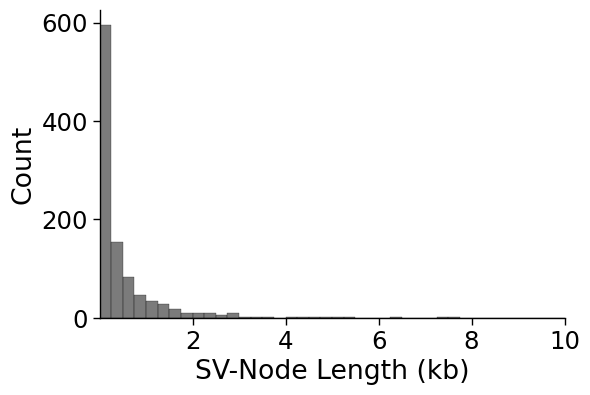

In [160]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(PG_SVNodes_PASS_DF["SeqLength"].values, bins = np.arange(0, 40000, 250), color = '#4F4F4F' )  
sns.despine()

plt.xlim(0, 10000)
plt.xlabel("SV-Node Length (kb)")


x_tick_loc = [2000, 4000, 6000, 8000, 10000]
x_tick_label = [2, 4, 6, 8, 10]

plt.xticks(x_tick_loc, x_tick_label )

plt.show()

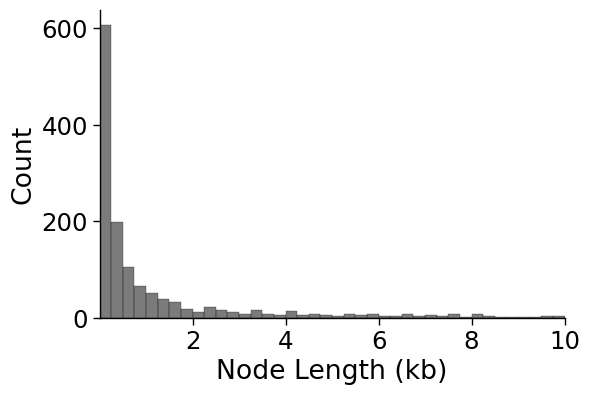

In [161]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(PG_Nodes_KmerComp_DF["SeqLength"].values, bins = np.arange(0, 40000, 250), color = '#4F4F4F' )  
sns.despine()

plt.xlim(0, 10000)
plt.xlabel("Node Length (kb)")


x_tick_loc = [2000, 4000, 6000, 8000, 10000]
x_tick_label = [2, 4, 6, 8, 10]

plt.xticks(x_tick_loc, x_tick_label )

plt.show()

#### Preparation - Breakdown core and SV nodes

In [162]:
PG_CoreNodes_All_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == False")

PG_SVNodes_All_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == True")
PG_SVNodes_PASS_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength >= 31")     
PG_SVNodes_Sub31bp_DF = PG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength < 31")     


In [163]:
PG_CoreNodes_All_DF.shape

(458, 8)

In [164]:
PG_SVNodes_All_DF.shape

(1023, 8)

In [165]:
PG_SVNodes_PASS_DF.shape

(1022, 8)

In [166]:
PG_CoreNodes_All_DF["SeqLength"].sum()

3921235

In [167]:
PG_CoreNodes_All_DF.query("MaxJC_ToOtherNode < 0.05")["SeqLength"].sum()

3917648

In [168]:
PG_SVNodes_PASS_DF["SeqLength"].sum()

512376

In [169]:
PG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05")["SeqLength"].sum()

69058

In [170]:
PG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv >= 0.05")["SeqLength"].sum()

443318

In [171]:
PG_SVNodes_PASS_DF["SeqLength"].sum()

512376

In [172]:
PG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode < 0.05")["SeqLength"].sum()

460232

In [173]:
PG_SVNodes_PASS_DF.head(20)

,NodeID,SeqLength,N_Asms,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,MaxJC_ToOtherNode
0,FJTMAZPRVD,129,0,1.000000,0.0,0.0,True,0.000000
3,OSJIRAGCXW,574,151,1.000000,0.0,0.0,True,0.000000
4,ELULSJQAGV,110,0,0.637500,0.0,0.0,True,0.025000
7,RVLKLWMJHG,136,0,1.000000,0.0,0.0,True,0.132075
9,GAFJQYTNYN,285,83,1.000000,0.0,0.0,True,0.015686
10,PBCOBFZSJC,499,150,1.000000,0.0,0.0,True,0.000000
11,LHGNEQTWJP,119,0,0.910112,0.0,0.0,True,0.112360
13,JHACCKWCAM,138,0,0.000000,0.0,0.0,True,0.000000
14,UGHNXKUHCM,551,82,1.000000,0.0,0.0,True,0.026871
15,KJQKUETHZU,108,0,1.000000,0.0,0.0,True,1.000000


In [174]:
PG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05")["SeqLength"].sum() 

69058

In [175]:
PG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 >= 0.05")["SeqLength"].sum() 

1355

In [176]:
PG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv >= 0.05")["SeqLength"].sum()

443318

In [177]:
PG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode >= 0.05")["SeqLength"].sum()

52144

In [178]:
PG_SVNodes_PASS_DF["SeqLength"].sum()

512376

#### Look at IS6110 sequences in SV nodes

In [179]:
PG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.5").shape

(5, 8)

In [180]:
PG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.5")

,NodeID,SeqLength,N_Asms,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,MaxJC_ToOtherNode
137,TGVEUNTRMZ,107,0,1.0,1.000000,1.000000,True,0.0
708,NFYLBYTRHB,618,2076,1.0,1.000000,1.000000,True,0.0
869,TEGNGWGODO,194,0,1.0,0.743902,0.743902,True,0.0
1129,EYWNVIFVOM,136,0,1.0,0.518868,0.518868,True,0.0
1372,CRDCTAWXQU,300,2090,1.0,1.000000,1.000000,True,0.0


In [181]:
PG_Nodes_KmerComp_DF.query("Jaccard_Cont_WiIS6110 > 0.5")

,NodeID,SeqLength,N_Asms,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,MaxJC_ToOtherNode
137,TGVEUNTRMZ,107,0,1.0,1.000000,1.000000,True,0.0
708,NFYLBYTRHB,618,2076,1.0,1.000000,1.000000,True,0.0
869,TEGNGWGODO,194,0,1.0,0.743902,0.743902,True,0.0
1129,EYWNVIFVOM,136,0,1.0,0.518868,0.518868,True,0.0
1372,CRDCTAWXQU,300,2090,1.0,1.000000,1.000000,True,0.0


#### Question 1: How many Core Nodes are there? What is there cumulative length?

In [128]:
PG_CoreNodes_All_DF.shape[0] 

458

In [129]:
PG_CoreNodes_All_DF["SeqLength"].sum()

3921235

#### Question 2: How many SV Nodes are there? What is there cumulative length?

In [130]:
PG_SVNodes_All_DF.shape[0]

1023

In [131]:
PG_SVNodes_All_DF["SeqLength"].sum()

512395

#### Question 3: How many SV nodes are too small to be evaluated using k-mer (31-mer) based comparison? (Filtered out for downstream evaluation)

Basically, how many have length < 31bp?

In [132]:
PG_SVNodes_Sub31bp_DF.shape[0]

1

In [133]:
PG_SVNodes_Sub31bp_DF["SeqLength"].sum() 

19

#### Question 4: How many SV nodes are long enough to be evaluated using k-mer (31-mer) based comparison? ("PASS" SV Nodes)

Basically, how many SV nodes have length >= 31bp?

In [134]:
PG_SVNodes_PASS_DF.shape[0]

1022

In [135]:
PG_SVNodes_PASS_DF["SeqLength"].sum() 

512376

#### Question 5: How many SV nodes have "unique sequence content within the graph"?

In [136]:
PG_SVNodes_UnqSeq_DF =  PG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode < 0.05")

In [137]:
PG_SVNodes_UnqSeq_DF.shape[0]

688

In [138]:
PG_SVNodes_UnqSeq_DF["SeqLength"].sum()   

460232

In [2]:
460232 / 512376 # len of unique SV nodes / total len of SV nodes

0.8982309866192015

In [140]:
302 / 1300 # 302 kb / 1,300 kb

0.2323076923076923

#### Question 6: Of "unique sequence content within the graph" nodes, how much is **also** "unique relative to H37Rv"?

In [141]:
PG_SVNodes_UnqSeq_UnqToRv_DF = PG_SVNodes_UnqSeq_DF.query("Jaccard_Cont_WiRv < 0.05")

In [142]:
PG_SVNodes_UnqSeq_UnqToRv_DF.shape[0]

86

In [143]:
PG_SVNodes_UnqSeq_UnqToRv_DF["SeqLength"].sum()  

65451

#### Question 7: How many SV nodes have "non-unique sequence content within the graph"?

In [144]:
PG_SVNodes_NoUnqSeq_DF = PG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode >= 0.05")

In [145]:
PG_SVNodes_NoUnqSeq_DF.shape[0]

334

In [1]:
PG_SVNodes_NoUnqSeq_DF["SeqLength"].sum()  

NameError: name 'PG_SVNodes_NoUnqSeq_DF' is not defined

#### Question 8: Of "non-unique sequence content within the graph" nodes, how much is **also** "unique relative to H37Rv"?

In [147]:
PG_SVNodes_NoUnqSeq_UnqToRv_DF = PG_SVNodes_NoUnqSeq_DF.query("Jaccard_Cont_WiRv < 0.05")

In [148]:
PG_SVNodes_NoUnqSeq_UnqToRv_DF.shape[0]

16

In [149]:
PG_SVNodes_NoUnqSeq_UnqToRv_DF["SeqLength"].sum()  

3607

#### Question 9: Of "non-unique sequence content within the graph" nodes, how many have k-mer overlap w/ sequences annotated as related to "phages & insertion sequences"?

In [150]:
PG_SVNodes_NoUnqSeq_ISandPhages_DF = PG_SVNodes_NoUnqSeq_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.5")

In [151]:
PG_SVNodes_NoUnqSeq_ISandPhages_DF.shape[0] 

4

In [152]:
PG_SVNodes_NoUnqSeq_ISandPhages_DF["SeqLength"].sum() 

729

#### - Question 10: Of the nodes that are classified as i) "non-unique sequence" & ii) "phages & insertion sequences", how many share k-mer content with the IS6110 element specifically?

In [153]:
PG_SVNodes_NoUnqSeq_ISandPhages_IS6110_DF = PG_SVNodes_NoUnqSeq_ISandPhages_DF.query("Jaccard_Cont_WiIS6110 > 0.5")

In [154]:
PG_SVNodes_NoUnqSeq_ISandPhages_IS6110_DF.shape[0]

0

In [155]:
PG_SVNodes_NoUnqSeq_ISandPhages_IS6110_DF["SeqLength"].sum()  

0

#### Question 11: How many SV nodes (& total length) are unique to H37Rv? (Independent of whether it is unique within the graph)

In [156]:
PG_SVNodes_UnqToRv_All_DF = PG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 & SeqLength >= 31")

In [157]:
PG_SVNodes_UnqToRv_All_DF.shape[0]

102

In [158]:
PG_SVNodes_UnqToRv_All_DF["SeqLength"].sum()  

69058

In [159]:
14815 + 51806

66621

In [160]:
15 + 52

67

In [161]:
66621 / 1283223 # len of "unique to H37Rv" SV nodes / total len of SV nodes

0.05191693104004526

In [162]:
67/ 1300 # 67 kb / 1,300 kb

0.05153846153846154

In [163]:
PG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05").shape

(102, 8)